This notebook is part of the `kikuchipy` documentation https://kikuchipy.org.
Links to the documentation won't work from the notebook.

# Load and save data

## Load patterns

### From a file

kikuchipy can read and write experimental EBSD patterns and EBSD master patterns
from/to multiple formats (see [supported formats](#supported-formats). To load
patterns from file use the [load()](reference.rst#kikuchipy.io._io.load)
function. Let's import the necessary libraries and read the Nickel EBSD test
data set directly from file (not via
[kikuchipy.data.nickel_ebsd()](reference.rst#kikuchipy.data.nickel_ebsd)):

In [20]:
# exchange inline for qt5 for interactive plotting from the pyqt package
%matplotlib inline

import dask.array as da
import hyperspy.api as hs
import kikuchipy as kp
import numpy as np
import matplotlib.pyplot as plt


datadir = "../kikuchipy/data/"
nordif_ebsd = "nordif/Pattern.dat"
s = kp.load(datadir + nordif_ebsd)
s

<EBSD, title: Pattern, dimensions: (3, 3|60, 60)>

Or, load the spherical projection of the northern hemisphere of an EBSD master
pattern for a 20 keV beam energy from a modified version of EMsoft's master
pattern file, returned from their `EMEBSDmaster.f90` program:

In [21]:
emsoft_master_pattern = (
 "emsoft_ebsd_master_pattern/ni_mc_mp_20kv_uint8_gzip_opts9.h5"
)
s_mp = kp.load(datadir + emsoft_master_pattern)
s_mp

<EBSDMasterPattern, title: ni_mc_mp_20kv_uint8_gzip_opts9, dimensions: (|401, 401)>

Both the spherical and Lambert projections of this master pattern data is
available via
[kikuchipy.data.nickel_master_pattern()](reference.rst#kikuchipy.data.nickel_master_pattern).

All file readers support accessing the data without loading it into memory (with
the [Dask library](https://docs.dask.org/en/latest)), which can be useful when
processing large data sets to avoid memory errors:

In [22]:
s_lazy = kp.load(datadir + nordif_ebsd, lazy=True)
s_lazy

<LazyEBSD, title: Pattern, dimensions: (3, 3|60, 60)>

Parts or all of the data can be read into memory by calling
[compute()](http://hyperspy.org/hyperspy-doc/current/api/hyperspy._signals.lazy.html#hyperspy._signals.lazy.LazySignal.compute):

In [23]:
s_lazy_copy = s_lazy.inav[:2, :].deepcopy()
s_lazy_copy.compute()
s_lazy_copy

[########################################] | 100% Completed |  0.1s


<EBSD, title: Pattern, dimensions: (2, 3|60, 60)>

In [24]:
s_lazy.compute()
s_lazy

[########################################] | 100% Completed |  0.1s


<EBSD, title: Pattern, dimensions: (3, 3|60, 60)>

<div class="alert alert-info">

Note

When lazily loaded EBSD patterns are processed, they are processed chunk by
chunk, which in many cases leads to longer processing times, so processing lazy
data sets should be done with some care. See the relevant
[HyperSpy user guide](http://hyperspy.org/hyperspy-doc/current/user_guide/big_data.html)
for information on how to do this.

</div>

Visualization of the data is done by navigating the navigation space and looking at the signal in each navigation point:

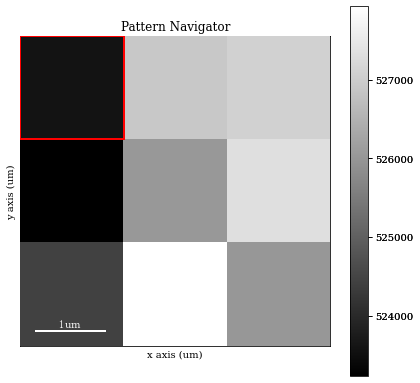

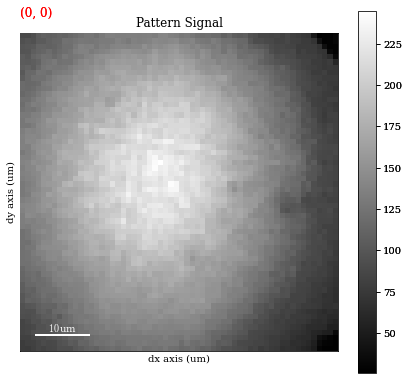

In [25]:
s.plot()

Upon loading, kikuchipy tries to read all scan information from the file and
stores everything it can read in the `original_metadata` attribute:

In [31]:
# s.original_metadata  # Long output

Also, some information may be stored in a standard location in the `metadata`
attribute where it can be used by EBSD class methods:

In [32]:
s.metadata

├── Acquisition_instrument
│   └── SEM
│       ├── Detector
│       │   └── EBSD
│       │       ├── azimuth_angle = 0.0
│       │       ├── binning = 1
│       │       ├── detector = NORDIF UF1100
│       │       ├── elevation_angle = 0.0
│       │       ├── exposure_time = 0.0035
│       │       ├── frame_number = -1
│       │       ├── frame_rate = 202
│       │       ├── gain = 0.0
│       │       ├── grid_type = square
│       │       ├── manufacturer = NORDIF
│       │       ├── sample_tilt = 70.0
│       │       ├── scan_time = 148
│       │       ├── static_background = array([[84, 87, 90, ..., 27, 29, 30],
       [87, 90, 93, ..., 27, 28, 30],
   ...  80, 82, ..., 28, 26, 26],
       [76, 78, 80, ..., 26, 26, 25]], dtype=uint8)
│       │       ├── version = 3.1.2
│       │       ├── xpc = -1.0
│       │       ├── ypc = -1.0
│       │       └── zpc = -1.0
│       ├── beam_energy = 20.0
│       ├── magnification = 200
│       ├── microscope = Hitachi SU-6600
│       └── working_distance = 24.7
├── General
│   ├── original_filename = ../kikuchipy/data/nordif/Pattern.dat
│   └── title = Pattern
├── Sample
│   └── Phases
│       └── 1
│           ├── atom_coordinates
│           │   └── 1
│           │       ├── atom = 
│           │       ├── coordinates = array([0., 0., 0.])
│           │       ├── debye_waller_factor = 0.0
│           │       └── site_occupation = 0.0
│           ├── formula = 
│           ├── info = 
│           ├── lattice_constants = array([0., 0., 0., 0., 0., 0.])
│           ├── laue_group = 
│           ├── material_name = Ni
│           ├── point_group = 
│           ├── setting = 0
│           ├── source = 
│           ├── space_group = 0
│           └── symmetry = 0
└── Signal
    ├── binned = False
    └── signal_type = EBSD

The number of patterns in horizontal and vertical direction, pattern size in
pixels, scan step size and detector pixel size is stored in the `axes_manager`
attribute:

In [12]:
s.axes_manager

<Axes manager, axes: (3, 3|60, 60)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |      3 |      0 |       0 |     1.5 |     um 
               y |      3 |      0 |       0 |     1.5 |     um 
---------------- | ------ | ------ | ------- | ------- | ------ 
              dx |     60 |        |       0 |       1 |     um 
              dy |     60 |        |       0 |       1 |     um

This information can be modified directly, and information in `metadata` and
`axes_manager` can also be modified by the
[EBSD](reference.rst#kikuchipy.signals.EBSD) class methods
[set_experimental_parameters()](reference.rst#kikuchipy.signals.EBSD.set_experimental_parameters),
[set_phase_parameters()](reference.rst#kikuchipy.signals.EBSD.set_phase_parameters),
[set_scan_calibration()](reference.rst#kikuchipy.signals.EBSD.set_scan_calibration) and
[set_detector_calibration()](reference.rst#kikuchipy.signals.EBSD.set_detector_calibration),
or the [EBSDMasterPattern](reference.rst#kikuchipy.signals.EBSDMasterPattern)
class methods [set_simulation_parameters()](reference.rst#kikuchipy.signals.EBSDMasterPattern.set_simulation_parameters) or
[set_phase_parameters()](reference.rst#kikuchipy.signals.EBSDMasterPattern.set_phase_parameters).
For example, to set or change the accelerating voltage, horizontal pattern
centre coordinate and static background pattern (stored as a
`numpy.ndarray`:

In [33]:
s.set_experimental_parameters(
    beam_energy=15,
    xpc=0.5073,
    static_background=plt.imread(
        datadir + "nordif/Background acquisition pattern.bmp"
    )
)

In addition to the HyperSpy provided `metadata`, `original_metadata` and
`axes_manager` properties, kikuchipy tries to read a [CrystalMap](https://orix.readthedocs.io/en/stable/reference.html#crystalmap) object with indexing results into a
`xmap` property and an
[EBSDDetector](reference.rst#kikuchipy.detectors.ebsd_detector.EBSDDetector)
object into a `detector` property:

In [36]:
s.xmap  # This is empty for this signal

In [35]:
s.detector

EBSDDetector (60, 60), px_size 1.0 um, binning 1, tilt 0, pc (0.5, 0.5, 0.5)

### From a NumPy array

An `EBSD` or `EBSDMasterPattern` signal can also be created directly from a
`numpy.ndarray`. To create a data set of (60 x 60) pixel patterns in a
(10 x 20) grid, i.e. 10 and 20 patterns in the horizontal and vertical scan
directions respectively, of random intensities:

In [40]:
s_np = kp.signals.EBSD(np.random.random((20, 10, 60, 60)))
s_np

<EBSD, title: , dimensions: (10, 20|60, 60)>

### From a Dask array

When processing large data sets, it is useful to load data lazily with the
Dask library. This can be done upon reading patterns [from a file](#from-a-file)
by setting `lazy=True` when using the `load()` function, or directly from a
`dask.array.Array`:

In [43]:
s_da = kp.signals.LazyEBSD(
    da.random.random((20, 10, 60, 60), chunks=(2, 10, 60, 60))
)
print(s_da)
s_da.data

<LazyEBSD, title: , dimensions: (10, 20|60, 60)>


dask.array<random_sample, shape=(20, 10, 60, 60), dtype=float64, chunksize=(2, 10, 60, 60), chunktype=numpy.ndarray>

### From a HyperSpy signal

HyperSpy provides the method
[set_signal_type()](http://hyperspy.org/hyperspy-doc/current/api/hyperspy.signal.html#hyperspy.signal.BaseSignal.set_signal_type)
to change between [BaseSignal](http://hyperspy.org/hyperspy-doc/current/api/hyperspy.signal.html#hyperspy.signal.BaseSignal) subclasses, of which
`EBSD`, `EBSDMasterPattern` and
[VirtualBSEImage](reference.rst#kikuchipy.signals.VirtualBSEImage) are three. To
get one of these objects from a [HyperSpy Signal2D](http://hyperspy.org/hyperspy-doc/current/api/hyperspy._signals.signal2d.html?highlight=signal2d#hyperspy._signals.signal2d.Signal2D):

In [25]:
s_hs = hs.signals.Signal2D(np.random.random((20, 10, 60, 60)))
s_hs

<Signal2D, title: , dimensions: (10, 20|60, 60)>

In [27]:
s_hs.set_signal_type("EBSD")
s_hs

<EBSD, title: , dimensions: (10, 20|60, 60)>

In [29]:
s_hs.set_signal_type("VirtualBSEImage")
s_hs

<VirtualBSEImage, title: , dimensions: (10, 20|60, 60)>

In [35]:
s_hs.set_signal_type("EBSDMasterPattern")
s_hs

<EBSDMasterPattern, title: , dimensions: (10, 20|60, 60)>

---
## Save patterns

To save experimental EBSD patterns to file use the
[save()](reference.rst#kikuchipy.signals.EBSD.save) method. For example, to save
an `EBSD` signal in an HDF5 file, with file name `patterns.h5`, in our default
[h5ebsd format](#h5ebsd):

In [30]:
s.save("patterns")

<div class="alert alert-danger">
    
Danger

If we want to overwrite an existing file:

```python
s.save("patterns.h5", overwrite=True)
```

</div>

If we want to save patterns in NORDIF's binary .dat format instead:

In [31]:
s.save("patterns.dat")

To save an `EBSDMasterPattern` to an HDF5 file, we use the [save method inherited from HyperSpy](http://hyperspy.org/hyperspy-doc/current/api/hyperspy.signal.html#hyperspy.signal.BaseSignal.save)
to write to [their HDF5 specification](http://hyperspy.org/hyperspy-doc/current/user_guide/io.html#hspy-hyperspy-s-hdf5-specification):

In [36]:
s_hs.save("master_pattern.hspy")
s_hs

Overwrite 'master_pattern.hspy' (y/n)?
 y


<EBSDMasterPattern, title: , dimensions: (10, 20|60, 60)>

These master patterns can then be read into an `EBSDMasterPattern` signal again
via HyperSpy's
[load()](http://hyperspy.org/hyperspy-doc/current/api/hyperspy.io.html#hyperspy.io.load):

In [38]:
s_mp2 = hs.load("master_pattern.hspy", signal_type="EBSDMasterPattern")
s_mp2

<EBSDMasterPattern, title: , dimensions: (10, 20|60, 60)>

<div class="alert alert-info">

Note

To save results from statistical decomposition (machine learning) of
patterns to file see the section
[Saving and loading results](http://hyperspy.org/hyperspy-doc/current/user_guide/mva.html#saving-and-loading-results) in HyperSpy's user guide. Note that the file extension
`.hspy` must be used upon saving, `s.save('patterns.hspy')`, as the
default extension in kikuchipy, `.h5`, yields a kikuchipy h5ebsd file. The
saved patterns can then be reloaded using HyperSpy's `load()` function and
passing the `signal_type="EBSD"` parameter
[as explained above](#From-a-HyperSpy-signal).

</div>

---
## Supported EBSD formats

Currently, kikuchipy has readers and writers for the following formats:

 Format                           Read  Write 
+=================================+======+=======+    +---------------------------------+------+-------+
    | Format                          | Read | Write |
    +=================================+======+=======+
    | Bruker Nano h5ebsd              | Yes  | No    |
    +---------------------------------+------+-------+
    | EDAX TSL h5ebsd                 | Yes  | No    |
    +---------------------------------+------+-------+
    | kikuchipy h5ebsd                | Yes  | Yes   |
    +---------------------------------+------+-------+
    | NORDIF binary                   | Yes  | Yes   |
    +---------------------------------+------+-------+
    | EMsoft simulated EBSD HDF5      | Yes  | No    |
    +---------------------------------+------+-------+
    | EMsoft EBSD master pattern HDF5 | Yes  | No    |
    +---------------------------------+------+-------+
| Bruker Nano h5ebsd              | Yes  | No    |
+---------------------------------+------+-------+
| EDAX TSL h5ebsd                 | Yes  | No    |
+---------------------------------+------+-------+
| kikuchipy h5ebsd                | Yes  | Yes   |
+---------------------------------+------+-------+
| NORDIF binary                   | Yes  | Yes   |
+---------------------------------+------+-------+
| EMsoft simulated EBSD HDF5      | Yes  | No    |
+---------------------------------+------+-------+
| EMsoft EBSD master pattern HDF5 | Yes  | No    |
+---------------------------------+------+-------+